In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets


In [2]:
from utilsGAN import Logger


In [3]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [4]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [5]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [7]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [8]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [10]:
loss = nn.BCELoss()
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [12]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [13]:
num_test_samples = 16
test_noise = noise(num_test_samples)

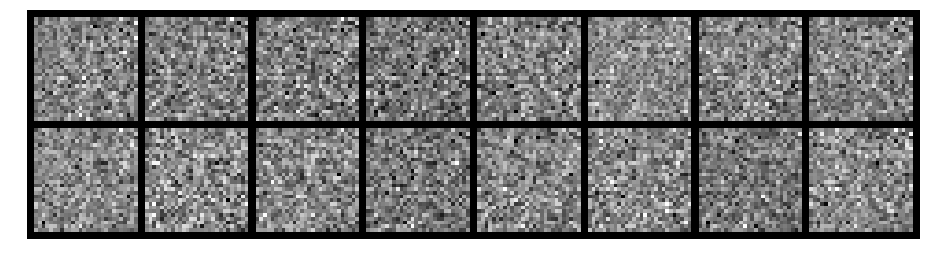

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3937, Generator Loss: 0.6957
D(x): 0.4949, D(G(z)): 0.4984


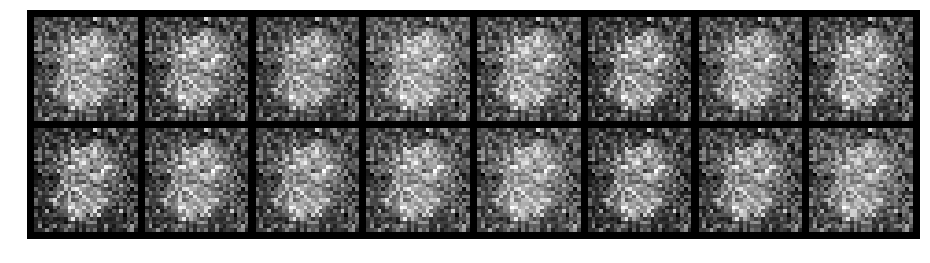

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.6213, Generator Loss: 0.8542
D(x): 0.5326, D(G(z)): 0.5357


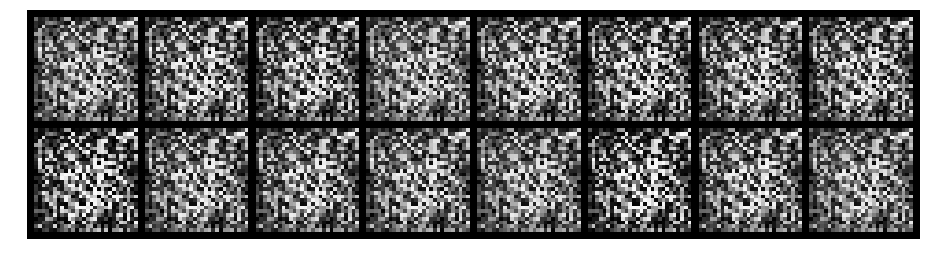

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.0484, Generator Loss: 5.6801
D(x): 0.9878, D(G(z)): 0.0339


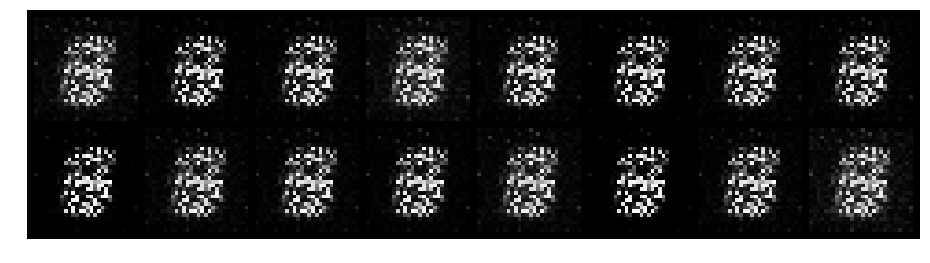

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.1255, Generator Loss: 4.0498
D(x): 0.9298, D(G(z)): 0.0486


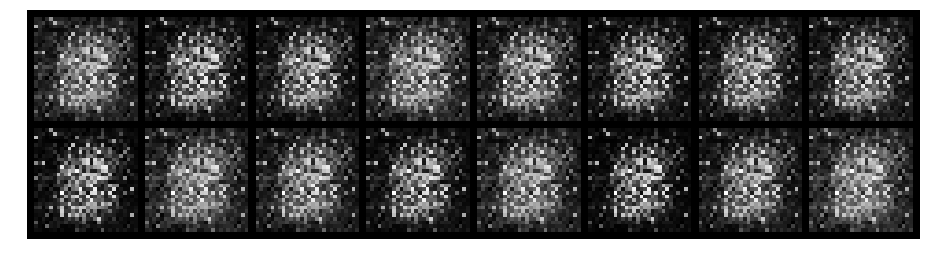

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 1.5776, Generator Loss: 1.0779
D(x): 0.7229, D(G(z)): 0.6574


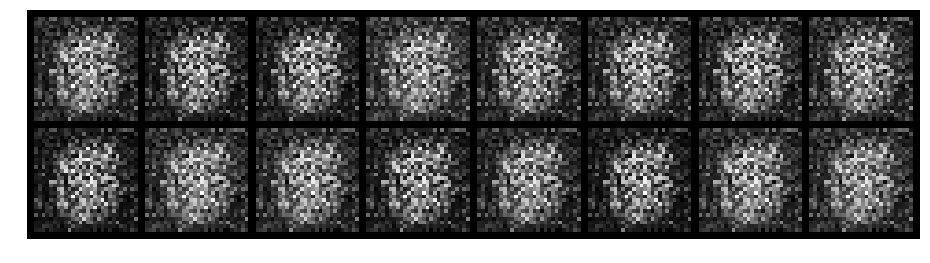

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.5585, Generator Loss: 2.7831
D(x): 0.8847, D(G(z)): 0.3053


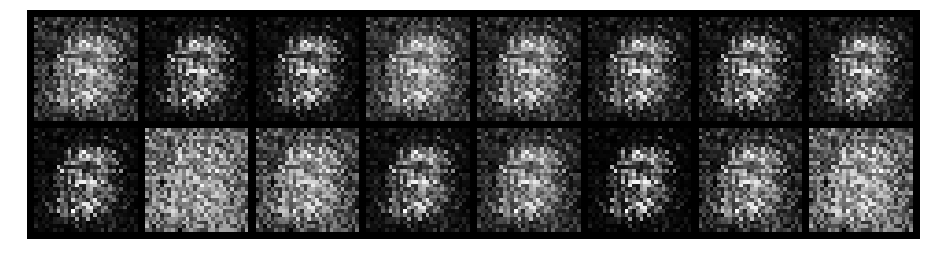

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.5258, Generator Loss: 3.7282
D(x): 0.8196, D(G(z)): 0.2245


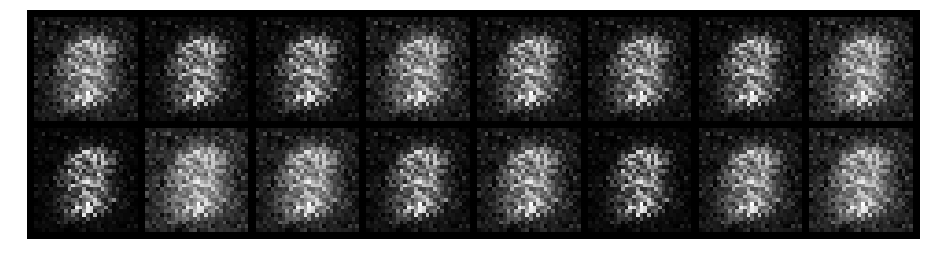

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.7739, Generator Loss: 2.2614
D(x): 0.7662, D(G(z)): 0.3073


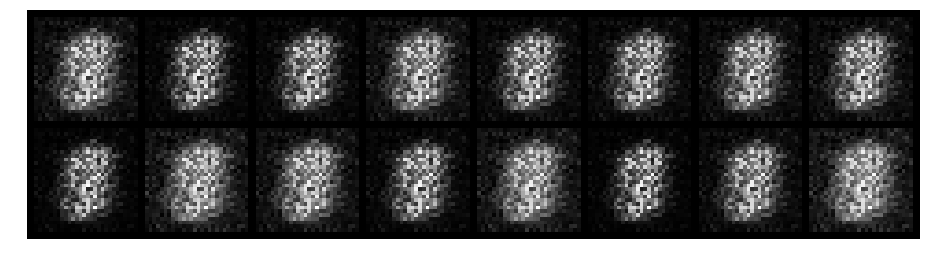

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 1.1837, Generator Loss: 1.1345
D(x): 0.5333, D(G(z)): 0.3917


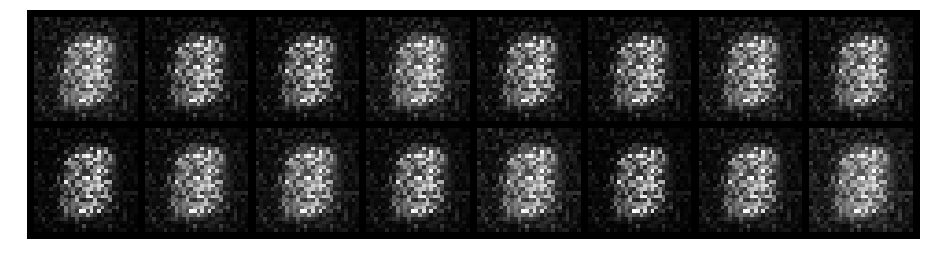

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.6482, Generator Loss: 1.6304
D(x): 0.7315, D(G(z)): 0.2416


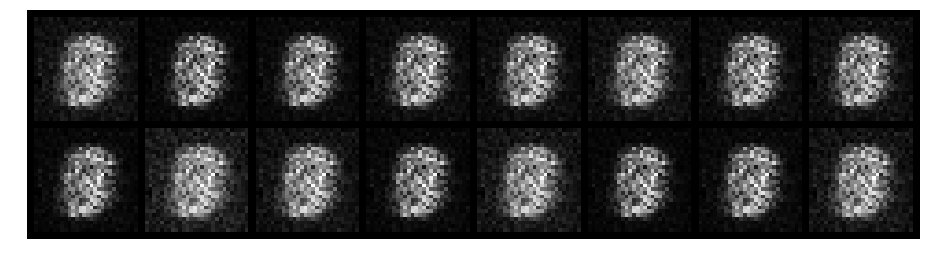

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.8271, Generator Loss: 2.1102
D(x): 0.7148, D(G(z)): 0.3277


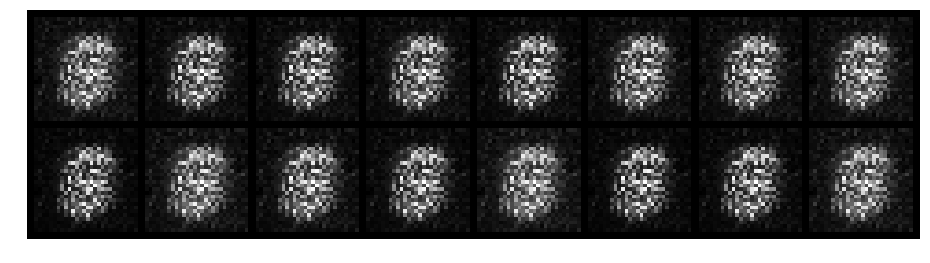

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.6716, Generator Loss: 2.2977
D(x): 0.7464, D(G(z)): 0.2466


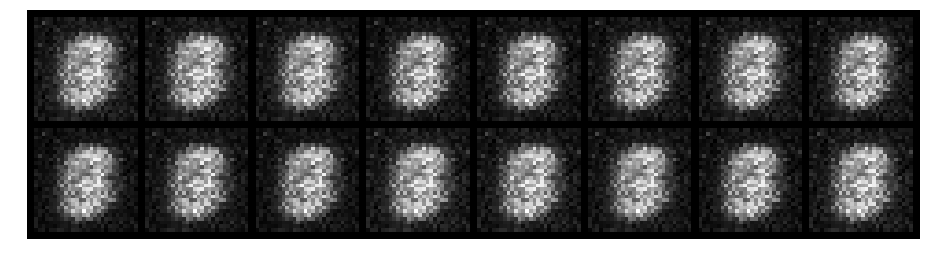

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 1.6440, Generator Loss: 0.5793
D(x): 0.6041, D(G(z)): 0.6227


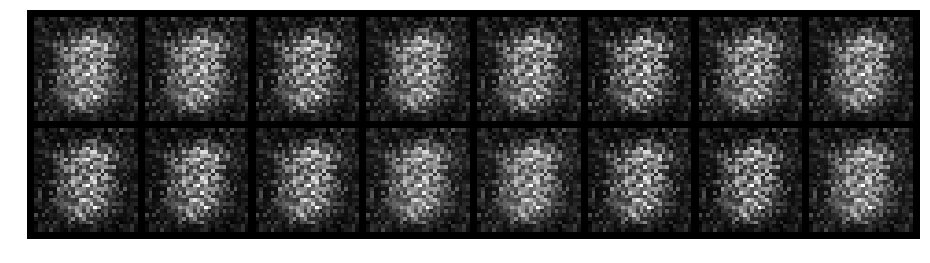

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.8814, Generator Loss: 1.4239
D(x): 0.7585, D(G(z)): 0.4147


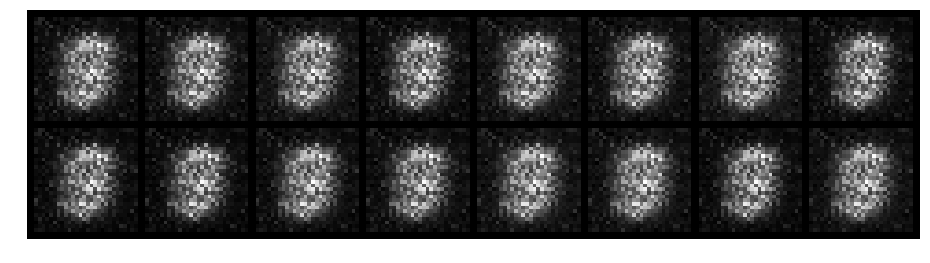

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 1.1875, Generator Loss: 1.1276
D(x): 0.7021, D(G(z)): 0.4646


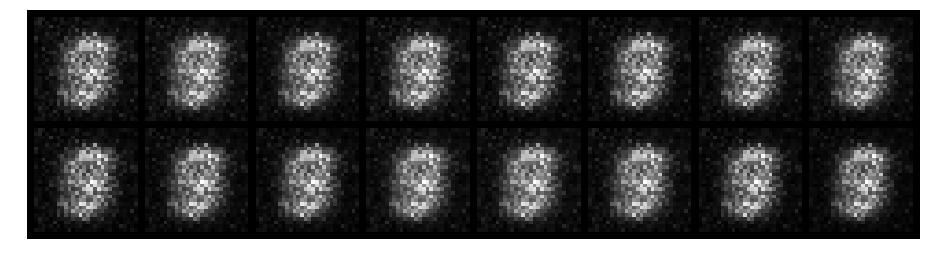

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.0841, Generator Loss: 4.7966
D(x): 0.9822, D(G(z)): 0.0572


KeyboardInterrupt: 

In [14]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
